In [1]:
import itertools
import numpy
import urllib,json
import pickle

RRR = RealField(100);
eps = var('eps');

#object: what to dump; name: string without ".pickle"
def pickletofile(object,name):
    thefile = open(name+".pickle",'wb');
    pickle.dump(object,thefile);
    thefile.close();
    return

#filename: string without ".pickle"
def unpicklefile(filename):
    thefile = open(filename+".pickle",'rb');
    theobj = pickle.load(thefile);
    thefile.close();
    return theobj

def savewits():
    pickletofile(SC,"stoch_complexity");
    pickletofile(SW,"witnesses");
    return;

#NOTE: use dictionary NC for strings of length 2 through 10.
#expects sigma to be an array/list, like usual
def nfacomplexity(sigma):
    theurl = "http://math.hawaii.edu/~bjoern/complexity-api/?string="+''.join(str(ch) for ch in sigma);
    response = urllib.urlopen(theurl);
    data = json.loads(response.read());
    return int(data.get('complexity'))

#returns bit flip of a string (given as a tuple)
def flip(sigma):
    l = [];
    for ch in sigma:
        l.append(1-ch);
    return tuple(l)

#flips every string in an iterable, returns a Set
def flipset(strings):
    theset = [];
    for s in strings:
        theset.append(flip(s));
    return Set(theset)

#switches the order of a pair of matrices
def switchmats(matpair):
    return [matpair[1],matpair[0]]

#expects accept_states to be a list
def accprob(transmatrices,sigma,accept_states):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols() == len(accept_states);
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    v = Matrix(Id[0]);
    f = Matrix(accept_states).transpose();
    
    A = v*Id;
    for ch in sigma:
        assert int(ch) == 0 or int(ch) == 1;
        A = A*transmatrices[int(ch)];
    A = A*f;
    return A[0][0];

#expects accept_states to be a matrix already
def accprob_vector(transmatrices,sigma,accept_states):
    #assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols() == len(accept_states);
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    v = Matrix(Id[0]);
    f = accept_states;
    
    A = v*Id;
    for ch in sigma:
        assert int(ch) == 0 or int(ch) == 1;
        A = A*transmatrices[int(ch)];
    A = A*f;
    return A[0][0];

 
def probmatrix(transmatrices,sigma):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols();
    A = identity_matrix(transmatrices[0].nrows());
    for ch in sigma:
        assert int(ch) == 0 or int(ch) == 1;
        A = A*transmatrices[int(ch)];
    return A;
    
def list_probs(transmatrices,accept_states=None,upto=11,startfrom=1):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols();
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    v = Matrix(Id[0]);
    if accept_states == None:
        f = Matrix(Id[n-1]).transpose();
    else:
        f = Matrix(accept_states).transpose();
    
    problist = []; #list of strings with their acceptance probabilities
    for i in range(startfrom,upto):
        l = list(itertools.product([0,1],repeat=i));
        for st in l:
            A = v*Id;
            for ch in st:
                assert int(ch) == 0 or int(ch) == 1;
                A = A*transmatrices[int(ch)];
            A = A*f;
            problist.append((st,A[0][0]));
        
    return problist;

#pass a list of binary strings to test, instead of a range
def list_probs_fromwords(transmatrices,accept_states,words=None):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols() == len(accept_states);
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    v = Matrix(Id[0]);
    f = Matrix(accept_states).transpose();
    if words == None:
        words = list(itertools.product([0,1],repeat=11));
    
    problist = []; #list of strings with their acceptance probabilities
    for st in words:
        A = v*Id;
        for ch in st:
            assert int(ch) == 0 or int(ch) == 1;
            A = A*transmatrices[int(ch)];
        A = A*f;
        problist.append((st,A[0][0]));
        
    return problist;
    
#expects a list in exactly the format returned by list_probs. if length>0, only looks at strings of exactly that length
def highest_prob(problist,length=0):
    assert length >= 0;
    if length == 0:
        sublist = problist;
    elif length > 0:
        sublist = [l for l in problist if len(l[0]) == length];
    highprob = max([l[1] for l in sublist]);
    highstr = [st for st in sublist if st[1] == highprob];
    return highstr;
    
def sortproblist(problist):
    return sorted(problist,key=lambda x:x[1],reverse=True);
    
    
#check transition matrices for rows summing to 1
def checkmatrices(P):
    assert P[0].nrows() == P[0].ncols() == P[1].nrows() == P[1].ncols();
    n = P[0].nrows();
    
    for i in range(2):
        for j in range(n):
            s = sum(P[i][j]);
            if s != 1:
                if s > 1:
                    relto1 = " > 1";
                elif s < 1:
                    relto1 = " < 1";
                print "P"+str(i)+" row "+str(j+1)+" sum is "+str(RRR(s))+relto1;
                
#expects a list in format returned by list_probs; if length>0, only consider strings of that length
def checkstd(problist,length=0):
    assert length >= 0;
    if length == 0:
        sublist = problist;
    elif length > 0:
        sublist = [l for l in problist if len(l[0]) == length];
    std_list = stats.std([p[1] for p in sublist]);
    high = highest_prob(sublist)[0];
    for p in sublist:
        if p[0] != high[0]:
            diff = high[1] - std_list;
            if diff <= p[1]:
                print str(high[0])+" is less than std = "+str(std_list)+" from "+str(p[0])+" (with prob "+str(p[1])+")";
                
#return list of pairs of nstates x nstates matrices
#(1/step) will be the increment of transition probabilities
#if half=True, don't include (a) both ways to order a
#pair of matrices; (b) pairs where both mats are the same.
#if info=True, print sizes of stuff along the way
def bruteforce(nstates,step,half=False,info=False):
    linit = Compositions(nstates+step,length=nstates);
    if info == True: print str(len(linit))+" partitions";
    lrows = [ [0]*nstates ];
    for t in linit:
        r = []; #do arithmetic on t by hand
        for i in t:
            r.append(QQ(i-1)/step);
        lrows.append(r);
    if info == True: print str(len(lrows))+" rows";
    mats = Tuples(lrows,nstates).list();
    if info == True: print str(len(mats))+" matrices";
    if half == False:
        mats2 = Tuples(mats,2).list();
    else:
        mats2 = list(itertools.combinations(mats,2));
    if info == True: print str(len(mats2))+" matrix pairs";
    Pnew = [];
    for P in mats2:
        Pnew.append([Matrix(QQ,P[0]),Matrix(QQ,P[1])]);
    return Pnew;

#do bruteforce() algo on only a given list of vectors (as lists)
#assumes all vectors are of the same length
#does NOT check vectors sum to 1
def bruteforcevecs(vecs,half=False,info=False):
    if info == True: print str(len(vecs))+" rows";
    n = len(vecs[0]);
    mats = Tuples(vecs,n).list();
    if info == True: print str(len(mats))+" matrices";
    if half == False:
        mats2 = Tuples(mats,2).list();
    else:
        mats2 = list(itertools.combinations(mats,2));
    if info == True: print str(len(mats2))+" matrix pairs";
    Pnew = [];
    for P in mats2:
        Pnew.append([Matrix(QQ,P[0]),Matrix(QQ,P[1])]);
    return Pnew;

#do bruteforce() algo using only the given list of transition
#probabilities as entries
def bruteforceprobs(nstates,probs,half=False,info=False):
    if info == True: print str(len(probs))+" possible entries";
    lrowsall = Tuples(probs,nstates).list();
    lrows = [];
    for r in lrowsall:
        s = sum(r);
        if s == 0 or s == 1: lrows.append(r);
    if info == True: print str(len(lrows))+" rows";
    mats = Tuples(lrows,nstates).list();
    if info == True: print str(len(mats))+" matrices";
    if half == False:
        mats2 = Tuples(mats,2).list();
    else:
        mats2 = list(itertools.combinations(mats,2));
    if info == True: print str(len(mats2))+" matrix pairs";
    Pnew = [];
    for P in mats2:
        Pnew.append([Matrix(QQ,P[0]),Matrix(QQ,P[1])]);
    return Pnew;

#expects a list of pairs of matrices as returned by bruteforce()
#strlen = length of strings to try, accept_states = vector (list)
def finduniques(matpairs,strlen,accept_states=None):
    uniques = [];
    if accept_states == None:
        n = matpairs[0][0].nrows();
        accept_states = list(identity_matrix(n)[n-1]);
    words = list(itertools.product([0,1],repeat=strlen));
    for P in matpairs:
        probs = list_probs_fromwords(P,accept_states,words);
        high = highest_prob(probs);
        if len(high) == 1:
            uniques.append([P,high]);
    return uniques;

#updates PFA complexities and adds new witnesses to SW
#uniqlist should be in the format output by finduniques()
#ASSUMES ALL MATRICES IN uniqlist ARE OF THE SAME SIZE!!!!!
#specify the _same_ list of accept states for all of them.
#return number of new witnesses added
def addwits(uniqlist,accept_states=None):
    n = uniqlist[0][0][0].nrows();
    count = 0;
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
    else:
        f = Matrix(accept_states).transpose();
    for u in uniqlist:
        s = u[1][0][0];
        if SC.has_key(s) == False or SC[s] > n:
            SC[s] = n;
        if SC[s] == n:
            try:
                ind = SW[s].index((u[0],f));
            except ValueError:
                SW[s].append((u[0],f));
                count = count + 1;
    return count;

#like addwits(), but only adds if there isn't a witness yet for
#each particular string
#uniqlist should be in the format output by finduniques()
#ASSUMES ALL MATRICES IN uniqlist ARE OF THE SAME SIZE!!!!!
#specify the _same_ list of accept states for all of them.
#return number of new witnesses added
def addwitsnew(uniqlist,accept_states=None):
    n = uniqlist[0][0][0].nrows();
    count = 0;
    for u in uniqlist:
        s = u[1][0][0];
        if len(SW[s]) > 0 and SC.has_key(s) == True:
            continue;
        count = count + addonewit(u,s,accept_states);
    return count;

#adds thewit (a pair of matrices) as a witness for sigma to SW
#also updates SC if appropriate
#only does it if this witnesses minimal complexity
#return 0 if nothing was added or updated;
#       1 if only a new witness;
#       2 if new witness and complexity updated.
def addonewit(thewit,sigma,accept_states=None):
    n = thewit[0].nrows();
    ret = 0;
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
    else:
        f = Matrix(accept_states).transpose();
    if SC.has_key(sigma) == False or SC[sigma] > n:
        SC[sigma] = n;
        ret = ret + 1;
    if SC[sigma] == n:
        try:
            ind = SW[sigma].index(thewit);
        except ValueError:
            SW[sigma].append((thewit,f));
            ret = ret + 1;
    return ret;

#same as addonewit(), but accept_states should now already be a
#matrix in the correct form
def addonewit_vec(thewit,sigma,accept_states):
    n = thewit[0].nrows();
    ret = 0;
    if SC.has_key(sigma) == False or SC[sigma] > n:
        SC[sigma] = n;
        ret = ret + 1;
    if SC[sigma] == n:
        try:
            ind = SW[sigma].index(thewit);
        except ValueError:
            SW[sigma].append((thewit,accept_states));
            ret = ret + 1;
    return ret;
    

#among PFAs given by matpairs, returns the first found which
#has sigma as its highest-prob word among strings of len(sigma).
#assumes all matrices have the same size.
def findwitness(matpairs,sigma,accept_states=None):
    if accept_states == None:
        n = matpairs[0][0].nrows();
        f = matrix(identity_matrix(n)[n-1]).transpose();
    else:
        f = matrix(accept_states).transpose();
    words = list(itertools.product([0,1],repeat=len(sigma)));
    words.remove(sigma);
    
    for P in matpairs:
        sigprob = accprob_vector(P,sigma,f);
        if sigprob == 0:
            continue;
        iscandidate = True;
        for s in words:
            testprob = accprob_vector(P,s,f);
            if testprob >= sigprob:
                iscandidate = False;
                break;
        if iscandidate == True:
            return P;
    return None;

#expects a list in the format given by finduniques
#sigma should be a TUPLE, not an array! (?)
#returns the first pair of matrices in uniqlist witnessing the
#PFA complexity of sigma
def firstwitness(uniqlist,sigma):
    return [u[0] for u in uniqlist if u[1][0][0] == sigma][0]

#expects a dictionary like SC or NC
#returns Set of keys in compdict with value=complexity
#restricts to length strlen if strlen>0; o/w no restr on length
#if less=True, returns keys with value<=complexity
def lookup(compdict,complexity,strlen=0,less=False):
    if strlen == 0 and less == False:
        return Set([k for k in compdict.keys() if compdict[k] == complexity]);
    elif strlen > 0 and less == False:
        return Set([k for k in compdict.keys() if compdict[k] == complexity and len(k) == strlen]);
    elif strlen == 0 and less == True:
        return Set([k for k in compdict.keys() if compdict[k] <= complexity]);
    elif strlen > 0 and less == True:
        return Set([k for k in compdict.keys() if compdict[k] <= complexity and len(k) == strlen]);


#return largest denominator in a pair of rational matrices
def matdenom(matpair):
    themax = 1;
    for i in range(2):
        for r in matpair[i]: #rows
            for e in r: #element
                d = QQ(e).denominator();
                themax = lcm(d,themax);
    return themax;

#return first witness for PFA complexity of sigma in SW with
#matdenom <= denom
def firstwitdenom(sigma,denom):
    if SW.has_key(sigma) == False or len(SW[sigma]) == 0:
        return None;
    for mats in SW[sigma]:
        if matdenom(mats[0]) <= denom:
            return mats;
    return None;

#return list of witnesses for PFA complexity of sigma in SW
#with matdenom = denom
def witsdenom(sigma,denom):
    if SW.has_key(sigma) == False or len(SW[sigma]) == 0:
        return None;
    thelist = [];
    for mats in SW[sigma]:
        if matdenom(mats[0]) == denom:
            thelist.append(mats);
    if thelist == []:
        return None;
    return thelist;

#return lowest denominator out of all witnesses for sigma in SW
def mindenom(sigma):
    if SW.has_key(sigma) == False or len(SW[sigma]) == 0:
        return None;
    return min([matdenom(w[0]) for w in SW[sigma]]);

#return highest denominator out of all witnesses for sigma in SW
def maxdenom(sigma):
    if SW.has_key(sigma) == False or len(SW[sigma]) == 0:
        return None;
    return max([matdenom(w[0]) for w in SW[sigma]]);

#determine if matpair represents an actual aut (as in Rabin)
def isactualaut(matpair):
    for i in range(2):
        for r in matpair[i]: #rows
            for e in r: #entries
                if e == 0:
                    return False;
    return True;

#substitute epses (tuple of epsilons, one per row) into matpairs
#for the variable eps
def matsub(matpairs,epses):
    assert len(epses[0]) == len(epses[1]) == matpairs[0].nrows();
    newmat = [ [], [] ];
    for i in range(2):
        for e in range(len(epses[i])):
            newmat[i].append(matpairs[i][e].substitute(eps=epses[i][e]));
    return [Matrix(newmat[0]), Matrix(newmat[1])];

#just returns the digraph of the aut described by matpair
def autgraph(matpair):
    n = matpair[0].nrows();
    gr = DiGraph(n,loops=True,multiedges=True);
    for l in range(2): #letter seen
        for i in range(n): #transition from state i...
            for j in range(n): #to state j
                if matpair[l][i][j] > 0:
                    gr.add_edge(i,j,label=str(l)+" ("+str(matpair[l][i][j])+")");
    return gr;

#plots the specified aut from SW
def autplotwit(sigma,ind):
    matpair = SW[sigma][ind][0];
    f = SW[sigma][ind][1];
    n = f.nrows();
    gr = autgraph(matpair);
    acc = [i for i in range(n) if f[i][0] == 1];
    notacc = Set(range(n)).difference(Set(acc)).list();
    return gr.plot(edge_labels=True,vertex_size=400,layout='spring',iterations=2,vertex_colors={'white': notacc,'yellow': acc});

#expects a matrix pair defining the automaton
def autplot(matpair,accept_states=None):
    n = matpair[0].nrows();
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
        acc = [n-1];
    else:
        f = Matrix(accept_states).transpose();
        acc = [i for i in range(n) if accept_states[i] == 1];
    gr = autgraph(matpair);
    notacc = Set(range(n)).difference(Set(acc)).list();
    return gr.plot(edge_labels=True,vertex_size=400,layout='spring',iterations=2,vertex_colors={'white': notacc,'yellow': acc});

#expects a digraph (probably the output of autgraph())
def autgraphplot(autg,accept_states=None):
    n = autg.order();
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
        acc = [n-1];
    else:
        f = Matrix(accept_states).transpose();
        acc = [i for i in range(n) if accept_states[i] == 1];
    notacc = Set(range(n)).difference(Set(acc)).list();
    return autg.plot(edge_labels=True,vertex_size=400,layout='spring',iterations=2,vertex_colors={'white': notacc,'yellow': acc});

In [2]:
#run immediately when restarting
SC = unpicklefile("stoch_complexity");
NC = unpicklefile("nfa_complexity");
SW = unpicklefile("witnesses");

In [134]:
#STATS
print len(SC)
for l in range(3,11):
    if l<9:
        top=4;
    else:
        top=5;
    for c in range(1,top):
        print "len "+str(l)+" complexity "+str(c)+": "+str(lookup(SC,c,l).cardinality())+" (NFA: "+str(lookup(NC,c,l).cardinality())+")"
    nu = lookup(SC,100,l,less=True).cardinality();
    if nu < 2^l:
        print "total classified "+str(nu)+"/"+str(2^l);
    witsum = sum([len(SW[k]) for k in SW.keys() if len(k)==l]);
    print "total witnesses "+str(witsum);
    print ""
print "# strings of each length with PFA=NFA complexity:"
for l in range(3,11):
    print str(l)+": "+str(len([k for k in SC.keys() if len(k) == l and SC[k] == NC[k]]))

1054
len 3 complexity 1: 2 (NFA: 2)
len 3 complexity 2: 6 (NFA: 6)
len 3 complexity 3: 0 (NFA: 0)
total witnesses 6

len 4 complexity 1: 2 (NFA: 2)
len 4 complexity 2: 14 (NFA: 6)
len 4 complexity 3: 0 (NFA: 8)
total witnesses 406

len 5 complexity 1: 2 (NFA: 2)
len 5 complexity 2: 20 (NFA: 6)
len 5 complexity 3: 10 (NFA: 24)
total witnesses 354

len 6 complexity 1: 2 (NFA: 2)
len 6 complexity 2: 28 (NFA: 6)
len 6 complexity 3: 34 (NFA: 26)
total witnesses 658

len 7 complexity 1: 2 (NFA: 2)
len 7 complexity 2: 32 (NFA: 6)
len 7 complexity 3: 94 (NFA: 22)
total witnesses 182

len 8 complexity 1: 2 (NFA: 2)
len 8 complexity 2: 40 (NFA: 6)
len 8 complexity 3: 214 (NFA: 20)
total witnesses 754

len 9 complexity 1: 2 (NFA: 2)
len 9 complexity 2: 44 (NFA: 6)
len 9 complexity 3: 309 (NFA: 20)
len 9 complexity 4: 2 (NFA: 78)
total classified 357/512
total witnesses 746

len 10 complexity 1: 2 (NFA: 2)
len 10 complexity 2: 23 (NFA: 6)
len 10 complexity 3: 137 (NFA: 20)
len 10 complexity 4: 7 (

In [3]:
test2x2 = bruteforce(2,2);
test2x3 = bruteforce(2,3);
test2x4 = bruteforce(2,4);
test2x5 = bruteforce(2,5);
test2x6 = bruteforce(2,6);
test2x7 = bruteforce(2,7);
test2x8 = bruteforce(2,8);
half3x2 = bruteforce(3,2,half=True);

somevecs = [ [1,0,0],[0,1,0],[0,0,1],[0,0,0],[1/4,1/4,1/2],
           [1/4,1/2,1/4],[1/2,1/4,1/4]];
some3x4 = bruteforcevecs(somevecs,half=True);

l3 = Set(itertools.product([0,1],repeat=3));
l4 = Set(itertools.product([0,1],repeat=4));
l5 = Set(itertools.product([0,1],repeat=5));
l6 = Set(itertools.product([0,1],repeat=6));
l7 = Set(itertools.product([0,1],repeat=7));
l8 = Set(itertools.product([0,1],repeat=8));
l9 = Set(itertools.product([0,1],repeat=9));
l10 = Set(itertools.product([0,1],repeat=10));
l11 = Set(itertools.product([0,1],repeat=11));

In [ ]:
half3x3 = bruteforce(3,3,half=True);
print len(half3x3);
test2x10 = unpicklefile("test2x10");
print len(test2x10);
test2x15 = unpicklefile("test2x15");
print len(test2x15);
test2x20 = unpicklefile("test2x20");
print len(test2x20);
test3x2 = unpicklefile("test3x2");
print len(test3x2);
#test4x1 = unpicklefile("test4x1");
#test3x4 = unpicklefile("test3x4");

In [5]:
print len(test2x2);
print len(test2x3);
print len(test2x4);
print len(test2x5);
print len(test2x6);
print len(test2x7);
print len(test2x8);
print len(half3x2);
print len(some3x4);

256
625
1296
2401
4096
6561
10000
58653
58653


In [9]:
test3x3 = unpicklefile("test3x3");
print len(test3x3);
test2x29 = unpicklefile("test2x29");
print len(test2x29);
test2x36 = unpicklefile("test2x36");
print len(test2x36);

117649
1771561


In [66]:
A1 = [Matrix(QQ,[[2/5,3/5],[1,0]]), Matrix(QQ,[[4/5,1/5],[2/5,3/5]])];
listA1 = list_probs(A1,[0,1],startfrom=5,upto=6);
print highest_prob(listA1)

[((0, 0, 1, 1, 0), 1278/3125)]


In [79]:
#A_N(00110)=3: https://math.hawaii.edu/wordpress/bjoern/complexity-of-00110/
#A_N(00010)=3
#A_N(00011)=3
#A_N(10111)=3
print [u for u in uniq1 if u[1][0][0] == (1,0,1,1,1)]

[[[[  0   0]
[3/5 2/5], [  0   1]
[2/5 3/5]], [((1, 0, 1, 1, 1), 459/625)]], [[[  0   0]
[2/5 3/5], [  0   1]
[1/5 4/5]], [((1, 0, 1, 1, 1), 522/625)]]]


In [76]:
A2 = [Matrix(QQ,[[0,1],[4/5,1/5]]), Matrix(QQ,[[2/5,3/5],[1/5,4/5]])];
listA2 = list_probs(A2,[0,1],startfrom=5,upto=6);
print highest_prob(listA2)

[((0, 0, 0, 1, 1), 471/625)]


In [78]:
A3 = [Matrix(QQ,[[2/5,3/5],[1,0]]), Matrix(QQ,[[3/5,2/5],[4/5,1/5]])];
listA3 = list_probs(A3,[0,1],startfrom=5,upto=6);
print highest_prob(listA3)

[((0, 0, 0, 1, 0), 1296/3125)]


In [80]:
A4 = [Matrix(QQ,[[0,0],[2/5,3/5]]), Matrix(QQ,[[0,1],[1/5,4/5]])];
listA4 = list_probs(A4,[0,1],startfrom=5,upto=6);
print highest_prob(listA4)

[((1, 0, 1, 1, 1), 522/625)]


In [86]:
#sortproblist(listA4)

In [153]:
uniq2 = finduniques(test1,6);
print len(uniq2)

725


In [154]:
print Set([u[1][0][0] for u in uniq2])

{(0, 0, 0, 0, 0, 0), (0, 0, 1, 1, 1, 1), (1, 0, 1, 0, 1, 0), (0, 0, 0, 0, 1, 0), (1, 1, 1, 1, 0, 1), (0, 1, 1, 1, 1, 1), (0, 1, 0, 0, 0, 0), (0, 1, 0, 1, 0, 1), (1, 1, 1, 1, 1, 0), (1, 1, 0, 1, 0, 1), (1, 1, 1, 1, 1, 1), (0, 0, 0, 0, 0, 1), (0, 0, 0, 1, 1, 1), (0, 0, 1, 1, 1, 0), (1, 1, 1, 0, 1, 0)}


In [85]:
print [u for u in uniq2 if u[1][0][0] == (1,1,1,0,1,0)]
#A_N(111010)=4

[[[[1/5 4/5]
[  1   0], [2/5 3/5]
[4/5 1/5]], [((1, 1, 1, 0, 1, 0), 7176/15625)]]]


In [158]:
uniq3 = finduniques(test1,8);
print len(uniq3)

725


In [90]:
print Set([u[1][0][0] for u in uniq3])

{(0, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 0, 1, 0, 1, 0), (1, 1, 1, 1, 1, 1, 1, 1), (0, 0, 0, 1, 1, 1, 1, 1), (0, 0, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 0, 0, 0, 1), (1, 0, 1, 0, 1, 0, 1, 0), (0, 1, 0, 1, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1, 1, 0), (1, 1, 1, 1, 1, 1, 1, 0), (1, 1, 0, 1, 0, 1, 0, 1), (0, 0, 0, 0, 0, 0, 1, 0), (0, 0, 1, 1, 1, 1, 1, 1), (0, 0, 0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 0, 1, 0, 1), (0, 0, 0, 0, 0, 1, 1, 1), (0, 1, 0, 0, 0, 0, 0, 0)}


In [159]:
uniq4 = finduniques(test1,9);
print len(uniq4)

749


In [100]:
print Set([u[1][0][0] for u in uniq4])

{(0, 1, 1, 1, 1, 1, 1, 1, 0), (0, 1, 0, 1, 0, 1, 0, 1, 0), (0, 0, 0, 0, 0, 1, 1, 1, 1), (0, 0, 0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 1, 1, 1, 1, 1, 1), (0, 0, 0, 0, 0, 1, 0, 1, 0), (0, 0, 0, 1, 0, 1, 0, 1, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 1, 1, 1, 1, 1, 1, 0), (1, 1, 1, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 0, 0, 0, 0, 1), (0, 0, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1), (0, 0, 0, 0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 1, 1, 1, 1, 0), (0, 1, 1, 1, 1, 1, 1, 1, 1), (1, 0, 1, 1, 1, 1, 1, 1, 1), (1, 0, 1, 0, 1, 0, 1, 0, 1), (0, 0, 0, 0, 1, 0, 1, 0, 1)}


In [15]:
test2x8 = bruteforce(2,8);
print len(test2x8)

4950


In [163]:
uniq2x8_6 = finduniques(test2x8,6);
print len(uniq2x8_6)

3623


In [104]:
print Set([u[1][0][0] for u in uniq2x8_6])

{(0, 0, 0, 0, 0, 0), (1, 0, 1, 0, 1, 0), (1, 1, 1, 1, 0, 1), (0, 1, 1, 1, 1, 1), (0, 0, 0, 0, 1, 1), (1, 1, 1, 1, 1, 0), (1, 1, 0, 1, 0, 1), (0, 0, 0, 0, 0, 1), (1, 1, 1, 0, 1, 0), (0, 0, 1, 1, 1, 1), (0, 0, 0, 0, 1, 0), (0, 1, 0, 0, 0, 0), (0, 1, 0, 1, 0, 1), (0, 0, 0, 1, 1, 1), (0, 0, 1, 1, 1, 0), (1, 1, 1, 1, 1, 1)}


In [164]:
uniq2x8_7 = finduniques(test2x8,7);
print len(uniq2x8_7)

3687


In [115]:
print Set([u[1][0][0] for u in uniq2x8_7])

{(0, 0, 1, 0, 1, 0, 1), (0, 0, 0, 1, 0, 1, 0), (1, 0, 1, 1, 1, 1, 1), (0, 0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 1, 1, 1, 1), (0, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 1, 1, 1), (0, 1, 1, 1, 1, 1, 1), (0, 0, 0, 0, 1, 1, 0), (1, 1, 1, 1, 1, 1, 1), (0, 0, 1, 1, 1, 1, 1), (0, 0, 1, 1, 1, 1, 0), (0, 0, 0, 0, 0, 1, 0), (1, 0, 1, 0, 1, 0, 1), (0, 0, 0, 0, 0, 1, 1), (1, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 1, 0, 1), (0, 1, 0, 1, 0, 1, 0)}


In [177]:
uniq2x8_5 = finduniques(test2x8,5);
print len(uniq2x8_5);
print Set([u[1][0][0] for u in uniq2x8_5])

3694
{(0, 0, 0, 0, 0), (1, 1, 1, 1, 0), (0, 0, 0, 1, 1), (0, 0, 1, 0, 1), (0, 1, 1, 1, 1), (1, 0, 1, 0, 1), (0, 0, 1, 1, 0), (0, 1, 1, 1, 0), (0, 1, 0, 1, 0), (0, 0, 1, 1, 1), (1, 1, 1, 1, 1), (0, 0, 0, 0, 1), (0, 0, 0, 1, 0), (1, 0, 1, 1, 1)}


In [265]:
uniq2x8_8 = finduniques(test2x8,8);
print len(uniq2x8_8);
print Set([u[1][0][0] for u in uniq2x8_8])

3625
{(0, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 0, 1, 0, 1, 0), (1, 1, 1, 1, 1, 1, 1, 1), (0, 0, 0, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 0, 1), (0, 0, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 0, 0, 0, 1), (1, 0, 1, 0, 1, 0, 1, 0), (0, 1, 0, 1, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1, 1, 0), (1, 1, 1, 1, 1, 1, 1, 0), (1, 1, 0, 1, 0, 1, 0, 1), (0, 0, 0, 0, 0, 0, 1, 0), (0, 0, 1, 1, 1, 1, 1, 1), (0, 0, 0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 0, 1, 0, 1), (0, 0, 0, 0, 0, 1, 1, 1), (0, 0, 0, 0, 1, 1, 1, 1), (0, 1, 0, 0, 0, 0, 0, 0)}


In [14]:
test2x6 = bruteforce(2,6);
print len(test2x6)

2016


In [187]:
uniq2x6_5 = finduniques(test2x6,5);
print len(uniq2x6_5);
print Set([u[1][0][0] for u in uniq2x6_5])

1373
{(0, 0, 0, 0, 0), (1, 1, 1, 1, 0), (0, 0, 0, 1, 1), (0, 1, 1, 1, 1), (1, 0, 1, 0, 1), (0, 0, 1, 1, 0), (0, 1, 1, 1, 0), (0, 1, 0, 1, 0), (0, 0, 1, 1, 1), (1, 1, 1, 1, 1), (0, 0, 0, 0, 1), (0, 0, 0, 1, 0), (1, 0, 1, 1, 1)}


In [188]:
uniq2x6_6 = finduniques(test2x6,6);
print len(uniq2x6_6);
uniq2x6_7 = finduniques(test2x6,7);
print len(uniq2x6_7);
print Set([u[1][0][0] for u in uniq2x6_6]).cardinality();
print Set([u[1][0][0] for u in uniq2x6_7]).cardinality();

1328
1369
14
17


In [192]:
test2x10 = bruteforce(2,10);
print len(test2x10)

10296


In [193]:
uniq2x10_5 = finduniques(test2x10,5);
print len(uniq2x10_5);
print Set([u[1][0][0] for u in uniq2x10_5]).cardinality()

8125
14


In [211]:
uniq2x10_4 = finduniques(test2x10,4);
print Set([u[1][0][0] for u in uniq2x10_4]).cardinality()

 11


In [218]:
uniq2x10_6 = finduniques(test2x10,6);
print len(uniq2x10_6);
print Set([u[1][0][0] for u in uniq2x10_6]).cardinality()

7999
16


In [233]:
uniq2x10_7 = finduniques(test2x10,7);
print len(uniq2x10_7);
print Set([u[1][0][0] for u in uniq2x10_7]).cardinality()

8111
19


In [243]:
test2x20 = bruteforce(2,20);
print len(test2x20)

116886


In [244]:
uniq2x20_4 = finduniques(test2x20,4);
print len(uniq2x20_4);
print Set([u[1][0][0] for u in uniq2x20_4]).cardinality()

102860
11


In [272]:
uniq2x20_5 = finduniques(test2x20,5);
print len(uniq2x20_5);
print Set([u[1][0][0] for u in uniq2x20_5]).cardinality()

103434
14


In [4]:
test3x2 = bruteforce(3,2);
print len(test3x2)

58653


In [6]:
uniq3x2_6 = finduniques(test3x2,4);
print len(uniq3x2_6)

22333


In [8]:
str3x2_6 = Set([u[1][0][0] for u in uniq3x2_6]);
print str3x2_6

{(1, 1, 0, 1), (1, 0, 0, 0), (1, 0, 1, 0), (0, 0, 0, 1), (1, 1, 1, 1), (0, 1, 0, 0), (0, 1, 1, 0), (0, 0, 1, 1), (1, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 0), (0, 1, 1, 1), (1, 0, 0, 1), (0, 0, 1, 0), (0, 0, 0, 0), (0, 1, 0, 1)}


In [9]:
len(str3x2_6.list())

16

In [10]:
test3_umats = [u[0] for u in uniq3x2_6];

In [11]:
uniqnest3 = finduniques(test3_umats,6);
print len(uniqnest3)

19729


In [13]:
strnest3 = Set([u[1][0][0] for u in uniqnest3]);
print len(strnest3.list())

64


In [ ]:
#implication: every string of length 6 has stochastic complexity
#at most 3.

In [37]:
nfacomplexity([1,1,1,0,0,1])

4

In [48]:
A5 = firstwitness(uniqnest3,(1,1,1,0,0,1));
listA5 = list_probs(A5,[0,0,1],startfrom=6,upto=7);
print highest_prob(listA5)

[((1, 1, 1, 0, 0, 1), 17/64)]


In [50]:
uniqnest4 = finduniques([u[0] for u in uniqnest3],7);
print len(uniqnest4)

17790


In [51]:
strnest4 = Set([u[1][0][0] for u in uniqnest4]);
print len(strnest4.list())

109


In [104]:
l7 = Set(itertools.product([0,1],repeat=7));
l7.difference(strnest4) #strings of length 7 NOT witnessed by
#this particular sample of auts

{(1, 1, 0, 1, 1, 1, 0), (0, 1, 0, 1, 1, 0, 0), (1, 0, 1, 0, 0, 0, 1), (1, 1, 0, 0, 1, 1, 1), (1, 1, 0, 1, 0, 0, 0), (0, 1, 1, 1, 0, 0, 0), (0, 1, 0, 0, 0, 1, 1), (1, 1, 1, 0, 0, 0, 0), (1, 1, 0, 0, 0, 1, 0), (0, 0, 1, 0, 1, 1, 0), (0, 0, 1, 1, 0, 0, 0), (0, 1, 0, 0, 1, 1, 0), (1, 1, 0, 0, 1, 0, 0), (1, 1, 0, 0, 1, 0, 1), (1, 0, 1, 1, 1, 0, 0), (1, 0, 0, 1, 1, 0, 1), (1, 0, 0, 0, 1, 0, 1), (0, 0, 0, 1, 1, 0, 0), (0, 0, 1, 1, 1, 0, 1)}

In [56]:
[(l,nfacomplexity(l)) for l in l7.difference(strnest4)]

[((1, 1, 0, 1, 1, 1, 0), 4),
 ((0, 1, 0, 1, 1, 0, 0), 4),
 ((1, 0, 1, 0, 0, 0, 1), 4),
 ((1, 1, 0, 0, 1, 1, 1), 4),
 ((1, 1, 0, 1, 0, 0, 0), 4),
 ((0, 1, 1, 1, 0, 0, 0), 4),
 ((0, 1, 0, 0, 0, 1, 1), 4),
 ((1, 1, 1, 0, 0, 0, 0), 4),
 ((1, 1, 0, 0, 0, 1, 0), 4),
 ((0, 0, 1, 0, 1, 1, 0), 4),
 ((0, 0, 1, 1, 0, 0, 0), 4),
 ((0, 1, 0, 0, 1, 1, 0), 4),
 ((1, 1, 0, 0, 1, 0, 0), 4),
 ((1, 1, 0, 0, 1, 0, 1), 4),
 ((1, 0, 1, 1, 1, 0, 0), 4),
 ((1, 0, 0, 1, 1, 0, 1), 4),
 ((1, 0, 0, 0, 1, 0, 1), 4),
 ((0, 0, 0, 1, 1, 0, 0), 4),
 ((0, 0, 1, 1, 1, 0, 1), 4)]

In [58]:
sample4 = uniqnest4[1000:3000];

In [63]:
len(Set([u[1][0][0] for u in sample4]).list())

43

In [64]:
uniqsample4 = finduniques([u[0] for u in sample4],8);

In [65]:
strsample4 = Set([u[1][0][0] for u in uniqsample4]);
print strsample4.cardinality()

49


In [68]:
firstwitness(uniqsample4,(0, 1, 1, 1, 0, 1, 1, 0))

[
[  0   0   1]  [1/2 1/2   0]
[1/2 1/2   0]  [  0   0   0]
[  0   0   0], [1/2   0 1/2]
]

In [69]:
firstwitness(uniqsample4,(0, 0, 0, 0, 1, 1, 1, 1))

[
[0 1 0]  [  0   0   1]
[1 0 0]  [1/2   0 1/2]
[0 0 0], [  0 1/2 1/2]
]

In [105]:
testwit = firstwitness(uniqsample4,(0, 1, 1, 0, 0, 0, 0, 1));
print testwit

[[1/2   0 1/2]
[1/2 1/2   0]
[  0   0   0], [  0   0   1]
[  0   0   0]
[  0 1/2 1/2]]


In [111]:
#what does this example (testwit) accept among longer strings?
testwitlist = list_probs(testwit,[0,0,1],startfrom=8,upto=15);

In [79]:
test3x3 = bruteforce(3,3);
print len(test3x3)

885115


In [94]:
test3x3sample = test3x3[560000:562000];

In [95]:
uniq3x3sample_7 = finduniques(test3x3sample,7);
print len(uniq3x3sample_7)

1326


In [96]:
str3x3sample_7 = Set([u[1][0][0] for u in uniq3x3sample_7]);
print str3x3sample_7.cardinality()

98


In [101]:
#these are strings that this sample witnesses of length 7 that
#weren't witnessed by the earlier "nest4" automata.
new3x3sample_7 = str3x3sample_7.intersection(l7.difference(strnest4));
print new3x3sample_7

{(0, 1, 0, 0, 1, 1, 0), (0, 1, 0, 1, 1, 0, 0), (1, 1, 0, 0, 1, 0, 1), (1, 1, 0, 0, 1, 1, 1), (1, 0, 0, 1, 1, 0, 1), (1, 0, 0, 0, 1, 0, 1), (0, 0, 1, 0, 1, 1, 0), (0, 0, 0, 1, 1, 0, 0), (0, 0, 1, 1, 1, 0, 1)}


In [119]:
#remaining 10 strings of length 7 we haven't witnessed yet
target7 = l7.difference(strnest4).difference(str3x3sample_7);
print target7

{(1, 1, 0, 1, 1, 1, 0), (0, 1, 1, 1, 0, 0, 0), (1, 0, 1, 0, 0, 0, 1), (1, 1, 0, 1, 0, 0, 0), (1, 1, 0, 0, 1, 0, 0), (1, 0, 1, 1, 1, 0, 0), (0, 1, 0, 0, 0, 1, 1), (1, 1, 1, 0, 0, 0, 0), (1, 1, 0, 0, 0, 1, 0), (0, 0, 1, 1, 0, 0, 0)}


In [120]:
test3x3sample2 = test3x3[400000:402000];
uniq3x3sample_7_2 = finduniques(test3x3sample2,7);
print len(uniq3x3sample_7_2)

1228


In [121]:
str3x3sample_7_2 = Set([u[1][0][0] for u in uniq3x3sample_7_2]);
print str3x3sample_7_2.intersection(target7)

{(1, 1, 0, 1, 1, 1, 0), (1, 1, 0, 0, 0, 1, 0), (1, 0, 1, 1, 1, 0, 0)}


In [122]:
#remaining 7 strings of length 7
target7_2 = target7.difference(str3x3sample_7_2);
print target7_2

{(0, 1, 0, 0, 0, 1, 1), (0, 1, 1, 1, 0, 0, 0), (0, 0, 1, 1, 0, 0, 0), (1, 0, 1, 0, 0, 0, 1), (1, 1, 0, 1, 0, 0, 0), (1, 1, 1, 0, 0, 0, 0), (1, 1, 0, 0, 1, 0, 0)}


In [125]:
test3x3sample3 = test3x3[650000:652000];
uniq3x3sample_7_3 = finduniques(test3x3sample3,7);
print len(uniq3x3sample_7_3)

1160


In [126]:
str3x3sample_7_3 = Set([u[1][0][0] for u in uniq3x3sample_7_3]);
print str3x3sample_7_3.intersection(target7_2)

{(1, 0, 1, 0, 0, 0, 1)}


In [127]:
#remaining 6 strings of length 7
target7_3 = target7_2.difference(str3x3sample_7_3);
print target7_3

{(0, 1, 0, 0, 0, 1, 1), (0, 1, 1, 1, 0, 0, 0), (0, 0, 1, 1, 0, 0, 0), (1, 1, 0, 1, 0, 0, 0), (1, 1, 1, 0, 0, 0, 0), (1, 1, 0, 0, 1, 0, 0)}


In [136]:
test3x3sample4 = test3x3[390000:392000];
uniq3x3sample_7_4 = finduniques(test3x3sample4,7);
print len(uniq3x3sample_7_4)

1313


In [137]:
str3x3sample_7_4 = Set([u[1][0][0] for u in uniq3x3sample_7_4]);
print str3x3sample_7_4.intersection(target7_3)

{(0, 1, 0, 0, 0, 1, 1)}


In [303]:
#remaining 5 strings of length 7
target7_4 = target7_3.difference(str3x3sample_7_4);
print target7_4

{(1, 1, 1, 0, 0, 0, 0), (0, 0, 1, 1, 0, 0, 0), (1, 1, 0, 0, 1, 0, 0), (0, 1, 1, 1, 0, 0, 0), (1, 1, 0, 1, 0, 0, 0)}


In [305]:
test3x3sample5 = test3x3[501000:503000];
uniq3x3sample_7_5 = finduniques(test3x3sample5,7);
print len(uniq3x3sample_7_5)

897


In [306]:
str3x3sample_7_5 = Set([u[1][0][0] for u in uniq3x3sample_7_5]);
print str3x3sample_7_5.intersection(target7_4)

{(1, 1, 0, 0, 1, 0, 0), (1, 1, 0, 1, 0, 0, 0)}


In [307]:
#remaining 3 of length 7
target7_5 = target7_4.difference(str3x3sample_7_5);
print target7_5

{(1, 1, 1, 0, 0, 0, 0), (0, 0, 1, 1, 0, 0, 0), (0, 1, 1, 1, 0, 0, 0)}


In [315]:
test3x3sample6 = test3x3[503000:505000];
uniq3x3sample_7_6 = finduniques(test3x3sample6,7);
print len(uniq3x3sample_7_6)

1136


In [317]:
str3x3sample_7_6 = Set([u[1][0][0] for u in uniq3x3sample_7_6]);
print str3x3sample_7_6.intersection(target7_5)

{(0, 1, 1, 1, 0, 0, 0)}


In [318]:
#remaining 2 of length 7
target7_6 = target7_5.difference(str3x3sample_7_6);
print target7_6

{(1, 1, 1, 0, 0, 0, 0), (0, 0, 1, 1, 0, 0, 0)}


In [330]:
test3x3sample7 = test3x3[507000:509000];
uniq3x3sample_7_7 = finduniques(test3x3sample7,7);
print len(uniq3x3sample_7_7)

1425


In [331]:
str3x3sample_7_7 = Set([u[1][0][0] for u in uniq3x3sample_7_7]);
print str3x3sample_7_7.intersection(target7_6)

{}


In [336]:
nextsam = test3x3[499000:501000];
print target7_6[0],findwitness(nextsam,target7_6[0]);
print target7_6[1],findwitness(nextsam,target7_6[1]);

(1, 1, 1, 0, 0, 0, 0) None
(0, 0, 1, 1, 0, 0, 0) [[2/3 1/3   0]
[  0 2/3 1/3]
[2/3   0 1/3], [  1   0   0]
[  0   1   0]
[1/3   0 2/3]]


In [343]:
print target7_6[0],findwitness(test3x3[515000:520000],target7_6[0],[1,0,0]);

(1, 1, 1, 0, 0, 0, 0) [[  0   0   1]
[  0 1/3 2/3]
[2/3   0 1/3], [  0 1/3 2/3]
[1/3   0 2/3]
[1/3 1/3 1/3]]


In [380]:
print target7_6[0],findwitness(test3x3[600000:700000],target7_6[0]);

(1, 1, 1, 0, 0, 0, 0) [[  0   0   0]
[  0 1/3 2/3]
[1/3 2/3   0], [2/3   0 1/3]
[  0   0   0]
[  0 2/3 1/3]]


In [ ]:
l3 = Set(itertools.product([0,1],repeat=3));
for s in l3:
    if SC[s] == 2:
        print s,findwitness(test2x5,s);
        print ""

In [ ]:
for s in l4:
    if SC[s] == 2:
        print s,NC[s],findwitness(test2x5,s);
        print ""

In [95]:
eps = RRR(.00001);
eta = RRR(.00000000001);
P1 = [Matrix(QQ,[[1-eps,eps],[1/2+eps,1/2-eps]]), Matrix(QQ,[[eps,1-eps],[1-eps/10,eps/10]])];
listP1 = list_probs(P1,[0,1],startfrom=4,upto=5);
print highest_prob(listP1)
print ""
sortP1 = sortproblist(listP1);
print RR(sortP1[0][1] - sortP1[1][1]);
print ""
print sortP1

[((1, 1, 0, 1), 4999872502227473875121/5000000000000000000000)]

1.99985300317498e-6

[((1, 1, 0, 1), 4999872502227473875121/5000000000000000000000), ((0, 0, 0, 1), 249993125148122900011/250000000000000000000), ((0, 1, 1, 1), 99996900056099516001331/100000000000000000000000), ((1, 0, 0, 1), 187500062379377099989/250000000000000000000), ((0, 1, 0, 1), 2500077496625036024879/5000000000000000000000), ((1, 0, 1, 1), 2499925002402468925121/5000000000000000000000), ((1, 1, 1, 0), 2499897502677473875121/5000000000000000000000), ((0, 0, 1, 0), 124994375170622900011/250000000000000000000), ((1, 0, 1, 0), 62501312401877099989/250000000000000000000), ((0, 1, 0, 0), 62497500156872450011/250000000000000000000), ((1, 0, 0, 0), 1562515629374875001/12500000000000000000), ((0, 0, 1, 1), 129996800031074879/5000000000000000000000), ((1, 1, 1, 1), 2199953800375098669/100000000000000000000000), ((0, 1, 1, 0), 102497075036024879/5000000000000000000000), ((0, 0, 0, 0), 234368125124999/12500000000000000000), 

In [ ]:
sigma = (1,1,0,1);
uniqsig = finduniques(test2x6,4);
uniqmats = Set([u for u in uniqsig if u[1][0][0] == sigma]);
for u in uniqmats:
    print u;
    print ""

In [89]:
eps = RRR(.01);
P2 = [Matrix(QQ,[[2/3-eps,1/3+eps],[1/2+eps,1/2-eps]]), Matrix(QQ,[[eps,1-eps],[1-eps,eps]])];
listP2 = list_probs(P2,[0,1],startfrom=4,upto=5);
print highest_prob(listP2)
print ""
print sortproblist(listP2)

[((1, 1, 0, 1), 209351342658110152006727063107329999/321738731022393249110838386650000000)]

[((1, 1, 0, 1), 209351342658110152006727063107329999/321738731022393249110838386650000000), ((0, 1, 1, 1), 104155419800991866119551305882453583/160869365511196624555419193325000000), ((0, 0, 0, 1), 7415215796162273211192666845641707304364194355151050722227539767/12421897324787989452513299920734809579317031958620987786700000000), ((1, 0, 0, 1), 187674966398480944936601085659632559/321738731022393249110838386650000000), ((0, 1, 0, 1), 2317092982363811420421890843638948524236069793400482021612697133/4140632441595996484171099973578269859772343986206995928900000000), ((1, 0, 1, 1), 157326189851789163625504495986024999/321738731022393249110838386650000000), ((1, 1, 1, 0), 78132226019707632951719364655041633/160869365511196624555419193325000000), ((0, 0, 1, 0), 1788534245857418317175990786240404248137417818119415911206566739/4140632441595996484171099973578269859772343986206995928900000000), ((1, 0, 1,

In [241]:
l4 = Set(itertools.product([0,1],repeat=4));
l5 = Set(itertools.product([0,1],repeat=5));
l4_not2 = Set([s for s in SC.keys() if len(s) == 4 and SC[s] > 2]);
l5_not2 = Set([s for s in SC.keys() if len(s) == 5 and SC[s] > 2]);
print l4_not2 #strings of len 4 not yet known A_S=2
print l5_not2 #strings of length 5 not yet known A_S=2
#note, there are only 8 str each of len 4 & 5 of A_N<=2.

{}
{(0, 1, 0, 1, 1), (1, 0, 0, 1, 0), (1, 1, 0, 1, 1), (0, 1, 1, 0, 1), (1, 0, 0, 1, 1), (1, 0, 1, 1, 0), (0, 1, 1, 0, 0), (1, 0, 1, 0, 0), (0, 1, 0, 0, 1), (0, 0, 1, 0, 0)}


In [96]:
print SC[(1,1,1,0,0,0,0)],SC[(1,1,1,0,0,0,0,0)]

2 2


In [225]:
#print findwitness(test2x8,(1,1,0,0),[1,0]);
print findwitness(test2x8,(1,1,1,0,0,0,0),[1,0]);

[[3/4 1/4]
[5/8 3/8], [7/8 1/8]
[1/4 3/4]]


In [366]:
awit = findwitness(test2x8,(1,1,1,0,0,0),[1,0]);
if awit != None:
    print addonewit(awit,(1,1,1,0,0,0),[1,0])

1


In [41]:
test2x2half = copy(test2x2);
for mats in test2x2half:
    test2x2half.remove(switchmats(mats));
print len(test2x2half)

128


In [151]:
print [s for s in lookup(SC,3,8) if len(SW[s])==0 or mindenom(s) > 2]

[(0, 0, 1, 1, 0, 1, 0, 0), (0, 0, 0, 1, 1, 0, 1, 0), (1, 1, 1, 0, 0, 1, 0, 1), (1, 1, 0, 0, 1, 0, 1, 1)]


In [46]:
#to fix accidentally having added a wit with vec the wrong shape
for s in lookup(SC,3,8):
    for w in SW[s]:
        if w[1].nrows() != 3:
            print s,w,len(SW[s])
            #print addonewit(w[0],s,list(w[1].transpose()));
            print addonewit_vec(w[0],s,w[1].transpose());
            SW[s].remove(w)
            print ""

In [47]:
#make sure the bitflip of every string also has a witness
for s in l9:
    if len(SW[s])>0 and len(SW[flip(s)])==0:
        m = SW[s][0][0];
        f = SW[s][0][1];
        print flip(s),addonewit_vec(switchmats(m),flip(s),f);

(0, 1, 0, 0, 1, 0, 0, 0, 0) 2
(0, 1, 0, 0, 0, 0, 0, 0, 1) 2
(1, 0, 1, 0, 0, 1, 0, 0, 1) 2
(1, 0, 0, 0, 1, 0, 0, 0, 1) 2
(1, 0, 0, 1, 0, 0, 0, 1, 0) 2
(1, 0, 1, 0, 0, 0, 0, 1, 0) 2
(0, 0, 0, 1, 0, 0, 0, 1, 0) 2
(0, 1, 1, 1, 1, 1, 0, 1, 0) 2
(0, 0, 1, 0, 0, 1, 0, 0, 1) 2
(0, 0, 0, 0, 0, 1, 0, 0, 0) 2
(1, 0, 1, 0, 0, 0, 0, 0, 0) 2
(0, 1, 1, 1, 1, 1, 0, 1, 1) 2
(1, 0, 0, 1, 0, 0, 0, 0, 1) 2
(0, 1, 0, 1, 0, 0, 1, 0, 0) 2
(0, 0, 0, 0, 1, 0, 0, 0, 1) 2
(0, 0, 0, 0, 1, 0, 0, 1, 0) 2
(0, 0, 0, 0, 1, 0, 0, 0, 0) 2
(0, 0, 1, 0, 0, 0, 0, 0, 1) 2
(1, 0, 0, 0, 1, 0, 0, 0, 0) 2
(0, 0, 1, 1, 1, 1, 1, 0, 1) 2
(0, 0, 1, 0, 1, 0, 1, 0, 0) 2
(1, 0, 0, 0, 0, 1, 0, 0, 0) 2
(0, 1, 0, 0, 0, 0, 0, 1, 1) 2
(0, 0, 1, 0, 0, 0, 1, 0, 0) 2
(1, 0, 0, 0, 0, 0, 1, 1, 0) 2
(0, 0, 1, 0, 0, 1, 0, 0, 0) 2


In [215]:
c = 0;
for s in lookup(SC,3,5):
#for s in notmatching:
#for s in lookup(SC,3,8):
#for s in singles:
    #if len(SW[s]) > 0:# or mindenom(s) > 2:
    #    continue;
    if len(s) < 5 or SC[s] == 2:
        continue;
    c = c + 1;
    if c < 0:
        continue;
    if c > 50:
        break;
    sys.stdout.write("%d\r" % (c) );
    f = [1,0];
    wits = findwitness(test2x29[100500:500000:89],s,f);
    if wits != None:
        print s,wits,addonewit(wits,s,f);
        print "";
        print flip(s),switchmats(wits),addonewit(switchmats(wits),flip(s),f);
        print "";

In [191]:
savewits()

In [190]:
#really inefficient (for larger sets of strings)
c = 0;
for s in l9.difference(lookup(SC,2,9,less=True)):
    if len(SW[s]) > 0:
        continue;
    c = c + 1;
    if c < 0:
        continue;
    if c > 50:
        break;
    sys.stdout.write("%d\r" % (c) );
    f = [0,0,1];
    #wits = findwitness(test3x2[1::100],s,f);
    wits = findwitness(test3x3[269500:450000:91],s,f);
    #wits = findwitness(test2x15[::13],s,f);
    if wits != None:
        print s,wits,addonewit(wits,s,f);
        print "";
        print flip(s),switchmats(wits),addonewit(switchmats(wits),flip(s),f);
        print "";

(1, 1, 0, 0, 0, 1, 1, 0, 0) [[1/3 1/3 1/3]
[  0 1/3 2/3]
[1/3   0 2/3], [1/3 2/3   0]
[  0 2/3 1/3]
[  1   0   0]] 2

(0, 0, 1, 1, 1, 0, 0, 1, 1) [[1/3 2/3   0]
[  0 2/3 1/3]
[  1   0   0], [1/3 1/3 1/3]
[  0 1/3 2/3]
[1/3   0 2/3]] 2

(0, 1, 0, 0, 0, 1, 1, 0, 1) [[2/3 1/3   0]
[  0 1/3 2/3]
[2/3   0 1/3], [  0 1/3 2/3]
[  0 1/3 2/3]
[  1   0   0]] 2

(1, 0, 1, 1, 1, 0, 0, 1, 0) [[  0 1/3 2/3]
[  0 1/3 2/3]
[  1   0   0], [2/3 1/3   0]
[  0 1/3 2/3]
[2/3   0 1/3]] 2

(1, 0, 0, 1, 1, 1, 0, 0, 1) [[  0 1/3 2/3]
[2/3 1/3   0]
[  0 2/3 1/3], [1/3   0 2/3]
[  0 1/3 2/3]
[  1   0   0]] 2

(0, 1, 1, 0, 0, 0, 1, 1, 0) [[1/3   0 2/3]
[  0 1/3 2/3]
[  1   0   0], [  0 1/3 2/3]
[2/3 1/3   0]
[  0 2/3 1/3]] 2

(0, 1, 0, 0, 1, 1, 0, 1, 1) [[2/3 1/3   0]
[1/3 1/3 1/3]
[1/3   0 2/3], [  0 2/3 1/3]
[1/3   0 2/3]
[2/3 1/3   0]] 2

(1, 0, 1, 1, 0, 0, 1, 0, 0) [[  0 2/3 1/3]
[1/3   0 2/3]
[2/3 1/3   0], [2/3 1/3   0]
[1/3 1/3 1/3]
[1/3   0 2/3]] 2



In [210]:
sig = (0, 0, 1, 0, 0, 0, 0);
f = [0,1];
awit = findwitness(test2x20,sig,f);
if awit != None:
    print addonewit(awit,sig,f)
#no 2-state witnesses with s=20:
#(1,0,0,1,0,0)
#(0, 0, 1, 0, 0, 0, 0)
#with s=10:
#(0, 1, 1, 1, 0, 1, 1, 1)

In [182]:
singles = [k for k in SC.keys() if sum(k) == 1 and len(k) < 11];
for i in range(11):
    for k in [k for k in singles if len(k)>i and k[i]==1]:
        print len(k),k,SC[k],NC[k],"flip",SC[flip(k)],NC[flip(k)];
    print ""

3 (1, 0, 0) 2 2 flip 2 2
2 (1, 0) 2 2 flip 2 2
5 (1, 0, 0, 0, 0) 2 2 flip 2 2
7 (1, 0, 0, 0, 0, 0, 0) 2 2 flip 2 2
9 (1, 0, 0, 0, 0, 0, 0, 0, 0) 2 2 flip 2 2
10 (1, 0, 0, 0, 0, 0, 0, 0, 0, 0) 2 2 flip 2 2
6 (1, 0, 0, 0, 0, 0) 2 2 flip 2 2
4 (1, 0, 0, 0) 2 2 flip 2 2
8 (1, 0, 0, 0, 0, 0, 0, 0) 2 2 flip 2 2

5 (0, 1, 0, 0, 0) 2 3 flip 2 3
10 (0, 1, 0, 0, 0, 0, 0, 0, 0, 0) 2 3 flip 2 3
8 (0, 1, 0, 0, 0, 0, 0, 0) 2 3 flip 2 3
3 (0, 1, 0) 2 2 flip 2 2
9 (0, 1, 0, 0, 0, 0, 0, 0, 0) 2 3 flip 2 3
6 (0, 1, 0, 0, 0, 0) 2 3 flip 2 3
2 (0, 1) 2 2 flip 2 2
4 (0, 1, 0, 0) 2 3 flip 2 3
7 (0, 1, 0, 0, 0, 0, 0) 2 3 flip 2 3

9 (0, 0, 1, 0, 0, 0, 0, 0, 0) 3 4 flip 3 4
5 (0, 0, 1, 0, 0) 3 3 flip 3 3
4 (0, 0, 1, 0) 2 3 flip 2 3
6 (0, 0, 1, 0, 0, 0) 3 4 flip 3 4
8 (0, 0, 1, 0, 0, 0, 0, 0) 3 4 flip 3 4
3 (0, 0, 1) 2 2 flip 2 2
7 (0, 0, 1, 0, 0, 0, 0) 3 4 flip 3 4

9 (0, 0, 0, 1, 0, 0, 0, 0, 0) 3 5 flip 3 5
6 (0, 0, 0, 1, 0, 0) 3 4 flip 3 4
4 (0, 0, 0, 1) 2 2 flip 2 2
8 (0, 0, 0, 1, 0, 0, 0, 0) 3 5 flip 3 5


In [38]:
[w[0] for w in SW[(0,1,0,0)] if isactualaut(w[0]) == True]

[]

In [44]:
for k in SC.keys():
    if NC.has_key(k) == False:
        continue;
    if SC[k] > NC[k]:# and 4<len(k)<8:
        print k,SC[k],NC[k];

In [45]:
for k in SC.keys():
    if SC[k] == floor(len(k)/2) + 1:
        print k,SC[k];

(1, 0, 1, 1, 0) 3
(1, 0, 0, 1, 0) 3
(1, 0) 2
(1, 1, 0) 2
(0, 1, 1) 2
(1, 0, 1) 2
(0, 1, 1, 0, 0) 3
(0, 1, 0) 2
(0, 1, 0, 0, 1) 3
(0, 1, 0, 1, 1) 3
(1, 0, 1, 0, 0) 3
(1, 0, 0, 1, 1) 3
(0, 0, 1, 0, 0) 3
(1, 1, 0, 1, 1) 3
(0, 1) 2
(0, 1, 1, 0, 1) 3
(0, 0, 1) 2
(1, 0, 0) 2


In [331]:
print lookup(SC,3,6).intersection(lookup(NC,3,6))

{(1, 1, 0, 1, 1, 0), (0, 1, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1), (1, 0, 1, 0, 1, 1), (0, 0, 1, 0, 0, 1), (0, 1, 1, 0, 1, 1), (0, 0, 1, 1, 0, 0), (0, 1, 0, 1, 0, 0), (1, 0, 0, 0, 1, 1), (1, 0, 1, 1, 0, 1), (0, 1, 1, 1, 0, 0), (1, 0, 0, 1, 0, 0)}


In [43]:
notmatching = [s for s in SC.keys() if SC.has_key(flip(s))==True and SC[s] > SC[flip(s)]];
print len(notmatching)

0


In [41]:
for s in notmatching:
    print s,SC[s],flip(s),SC[flip(s)]

(1, 0, 0, 0, 0, 0, 0, 1, 0) 4 (0, 1, 1, 1, 1, 1, 1, 0, 1) 3


In [42]:
#to fix witnesses for notmatching (ONLY RUN ONCE!)
for s in notmatching:
    print s;
    SW[s] = [];
    m = SW[flip(s)][0][0];
    f = SW[flip(s)][0][1];
    print addonewit_vec(switchmats(m),s,f)

(1, 0, 0, 0, 0, 0, 0, 1, 0)
2


In [46]:
uniq2x8_9 = finduniques(test2x8,9);
print len(uniq2x8_9);
print Set([u[1][0][0] for u in uniq2x8_9]).difference(Set([k for k in SC.keys() if len(k) == 9 and SC[k] < 3]))

3681
{(0, 0, 0, 0, 1, 1, 1, 1, 1)}


In [89]:
uniq2x6_9_bw = finduniques(test2x6,9,[1,0]);
print len(uniq2x6_9_bw);
print Set([u[1][0][0] for u in uniq2x6_9_bw]).difference(Set([k for k in SC.keys() if len(k) == 9 and SC[k] < 3]))

1477
{(1, 1, 1, 1, 1, 1, 1, 0, 0), (0, 1, 0, 0, 0, 0, 0, 0, 0), (1, 1, 0, 0, 0, 0, 0, 0, 0), (1, 1, 1, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1, 1, 1), (1, 1, 1, 1, 0, 1, 0, 1, 0), (1, 1, 0, 1, 0, 1, 0, 1, 0), (1, 1, 1, 1, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 1, 1, 0), (0, 0, 0, 1, 1, 1, 1, 1, 0)}


In [131]:
#already tried with f=[0,1]
uniq2x10_9_bw = finduniques(test2x10,9,[1,0]);
print len(uniq2x10_9_bw);
print Set([u[1][0][0] for u in uniq2x10_9_bw]).difference(Set([k for k in SC.keys() if len(k) == 9 and SC[k] < 3]))

8361
{(1, 1, 1, 1, 1, 0, 1, 0, 1), (1, 1, 1, 1, 1, 1, 0, 1, 0), (1, 0, 0, 0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 1, 1, 0, 0, 0), (1, 1, 1, 1, 1, 0, 0, 0, 0), (1, 1, 1, 0, 1, 0, 1, 0, 1)}


In [356]:
uniq2x6_8_bw = finduniques(test2x6,8,[1,0]);
print len(uniq2x6_8_bw);
print Set([u[1][0][0] for u in uniq2x6_8_bw]).difference(Set([k for k in SC.keys() if len(k) == 8 and SC[k] < 3]))

3030
{}


In [357]:
addwits(uniq2x6_8_bw,[1,0])

In [240]:
uniq2x10_8_bw = finduniques(test2x10,8,[1,0]);
print len(uniq2x10_8_bw);
print Set([u[1][0][0] for u in uniq2x10_8_bw]).difference(Set([k for k in SC.keys() if len(k) == 8 and SC[k] < 3]))

8467
{(0, 0, 1, 0, 1, 0, 1, 0), (1, 1, 1, 1, 1, 0, 0, 0), (1, 1, 1, 1, 1, 1, 0, 0)}


In [ ]:
uniq2x10_7_bw = finduniques(test2x10,7,[1,0]);
print len(uniq2x10_7_bw);
print Set([u[1][0][0] for u in uniq2x10_7_bw]).difference(Set([k for k in SC.keys() if len(k) == 7 and SC[k] < 3]))

In [443]:
uniq2x2_8 = finduniques(test2x2,8);
print len(uniq2x2_8);
print Set([u[1][0][0] for u in uniq2x2_8])
print addwits(uniq2x2_8)

74
{(0, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 0, 0, 0, 0), (1, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1), (1, 0, 1, 0, 1, 0, 1, 0), (0, 1, 0, 1, 0, 1, 0, 1)}
38


In [320]:
#uniq2x4_10 = finduniques(test2x4,10);
print len(uniq2x4_10);
print Set([u[1][0][0] for u in uniq2x4_10]).difference(Set([k for k in SC.keys() if len(k) == 10 and SC[k] < 3]))

690
{}


In [105]:
print len([k for k in SW.keys() if len(SW[k]) == 0 and SC.has_key(k) and SC[k] > 1]);
print len([k for k in SW.keys() if len(SW[k]) > 0]);

3
1014


In [25]:
#uniq1 = finduniques(test3x3[101000:102000],6,[1,0,0]);
f1 = [0,0,1];
#uniq1 = finduniques(test2x29[203000:350000:47],5,f1);
uniq1 = finduniques(test3,9,f1);
print len(uniq1)
#print Set([u[1][0][0] for u in uniq1]).difference(lookup(SC,3,less=True)).cardinality()

28


In [28]:
#print addwits(uniq1,f1);
#only bother adding witnesses if we don't already have one
c = 0;
for u in uniq1:
    s = u[1][0][0];
    if not SW.has_key(s) or not SC.has_key(s) or SC[s] > u[0][0].nrows() or len(SW[s]) == 0:
        c = c + addonewit(u[0],s,f1);
print c

2


In [26]:
for s in Set([u[1][0][0] for u in uniq1]):
    if SC.has_key(s):
        print s,SC[s],NC[s];
    else:
        print s,"n/a",NC[s];

(1, 1, 1, 1, 1, 1, 1, 0, 0) 2 3
(0, 0, 0, 0, 0, 0, 0, 0, 0) 1 1
(0, 1, 1, 1, 1, 1, 1, 0, 0) 3 4
(1, 1, 1, 1, 1, 1, 1, 1, 0) 2 2
(0, 0, 0, 0, 0, 0, 0, 0, 1) 2 2
(1, 1, 1, 1, 1, 1, 1, 1, 1) 1 1
(0, 1, 1, 1, 1, 1, 0, 0, 1) n/a 4
(0, 1, 1, 1, 1, 1, 1, 1, 1) 2 2
(0, 0, 0, 0, 0, 0, 0, 1, 1) 2 3
(1, 0, 1, 0, 1, 0, 1, 0, 1) 2 2
(0, 0, 0, 0, 0, 0, 1, 1, 0) 2 4


In [29]:
savewits()

In [ ]:
print [len(SW[k]) for k in lookup(SC,2,10)]
print lookup(SC,2,10)

In [ ]:
[(k,SW[k][0],maxdenom(SW[k][0][0])) for k in lookup(SC,2,4) if len(SW[k]) > 0]

In [302]:
#sigma=1000 test
eps1 = QQ(.00001);
eta = eps1*5000
P3 = [Matrix(QQ,[[1/2+eps1,1/2-eps1],[1-eps1,eps1]]), Matrix(QQ,[[1/2+10*eps1,1/2-10*eps1],[0,0]])];
listP3 = list_probs(P3,[0,1],startfrom=4,upto=5);
print highest_prob(listP3)
print ""
print eps1,eta
print sortproblist(listP3)

[((1, 0, 0, 0), 390640623000074999/1250000000000000000)]

1/100000 1/20
[((1, 0, 0, 0), 390640623000074999/1250000000000000000), ((0, 0, 0, 0), 3906265621875074999/12500000000000000000), ((1, 0, 0, 1), 78113124000054999/250000000000000000), ((0, 0, 0, 1), 781103122875054999/2500000000000000000), ((0, 0, 1, 0), 468840620750049999/2500000000000000000), ((1, 0, 1, 0), 46881249125049999/250000000000000000), ((1, 1, 0, 0), 46880624500044999/250000000000000000), ((0, 0, 1, 1), 93749371275024999/500000000000000000), ((0, 1, 0, 0), 468721876749999999/2500000000000000000), ((1, 0, 1, 1), 9374374650024999/50000000000000000), ((1, 1, 0, 1), 9374374650024999/50000000000000000), ((0, 1, 0, 1), 93726875999979999/500000000000000000), ((1, 1, 1, 0), 3126875350014999/50000000000000000), ((0, 1, 1, 0), 31263126249969999/500000000000000000), ((1, 1, 1, 1), 625249999989999/10000000000000000), ((0, 1, 1, 1), 6251374774944999/100000000000000000)]


In [ ]:
[(k,firstwitdenom(k,2)) for k in lookup(SC,2) if len(SW[k])>0 and NC[k] > 2 and firstwitdenom(k,2) != None]

In [234]:
NC[(0, 1, 1, 1, 1, 1, 1, 1, 0, 0)]

4

In [10]:
witsdenom((0, 1, 1, 1, 1, 1, 1, 1, 0),2)

[(
[[  0   1]           
[1/2 1/2], [0 0]  [1]
[0 1]]          , [0]
),
 (
[[  0   1]               
[1/2 1/2], [1/2 1/2]  [1]
[  0   1]]          , [0]
)]

In [ ]:
[(k,NC[k],SW[k][0]) for k in SW.keys() if len(k) == 10 and len(SW[k]) > 0 and NC[k] > 2]

In [333]:
#test 2x2 normal form schematic combos
eps = var('eps');
rows = [(0,0),(1-eps,eps),(eps,1-eps),(1/2+eps,1/2-eps),(1/2-eps,1/2+eps)];
mats = Tuples(rows,2).list();
mats2 = Tuples(mats,2).list();
nf2x2 = [];
for P in mats2:
    nf2x2.append([Matrix(P[0]),Matrix(P[1])]);

In [ ]:
epses1 = [[1/100,1/100],[1/100,1/100]];
nf2x2_100 = [];
for P in nf2x2:
    nf2x2_100.append(matsub(P,epses1));
uniqnf2x2_100 = finduniques(nf2x2_100,5,[1,0]);
print len(uniqnf2x2_100)
print [u for u in uniqnf2x2_100 if SC[u[1][0][0]] > 2]

In [403]:
print Set([u[1][0][0] for u in uniqnf2x2_100]).difference(lookup(SC,2))

{(0, 0, 0, 0, 0), (1, 1, 1, 1, 1)}


In [104]:
len([k for k in SW.keys() if SC.has_key(k) and SC[k] == 3 and len(SW[k]) == 0])

3

In [227]:
for s in l4.difference(lookup(SC,1)):
    if s[0] == 1:
        continue;
    print s,NC[s],len(SW[s])
    print firstwitdenom(s,4)
    print ""

(0, 0, 0, 1) 2 300
([[1 0]
[0 0], [2/3 1/3]
[  0   0]], [0]
[1])

(0, 0, 1, 1) 3 2
([[  0   1]
[3/4 1/4], [3/4 1/4]
[1/2 1/2]], [1]
[0])

(0, 1, 0, 0) 3 15
([[  0   1]
[2/3 1/3], [  0   0]
[1/3 2/3]], [0]
[1])

(0, 1, 1, 0) 3 3
([[  0   1]
[1/2 1/2], [0 0]
[0 1]], [1]
[0])

(0, 0, 1, 0) 3 33
([[  0   1]
[2/3 1/3], [2/3 1/3]
[1/3 2/3]], [0]
[1])

(0, 1, 0, 1) 2 155
([[2/3 1/3]
[  1   0], [1/3 2/3]
[  1   0]], [0]
[1])

(0, 1, 1, 1) 2 264
([[2/3 1/3]
[  0   0], [1/3 2/3]
[  1   0]], [0]
[1])



In [37]:
sig=flip((0,0,1,1));
wits = findwitness(test2x4,sig,[1,0]);
print sig,wits

(1, 1, 0, 0) [[3/4 1/4]
[1/2 1/2], [  0   1]
[3/4 1/4]]


In [133]:
sum([len(SW[k]) for k in SW.keys()])

3637

In [28]:
#correctness check
c = 0;
for k in SW.keys():
    for W in SW[k]:
        sys.stdout.write(str(k)+"   %d\r" % (c) );
        #sys.stdout.flush();
        c = c + 1;
        if SC.has_key(k) and W[0].nrows() > SC[k]:
            print "mat size > SC",k,W;
            print "";
            SW[k].remove(W);
            continue;
        if findwitness([W[0]],k,W[1].list()) == None:
            print k,W;
            print "";
            SW[k].remove(W);

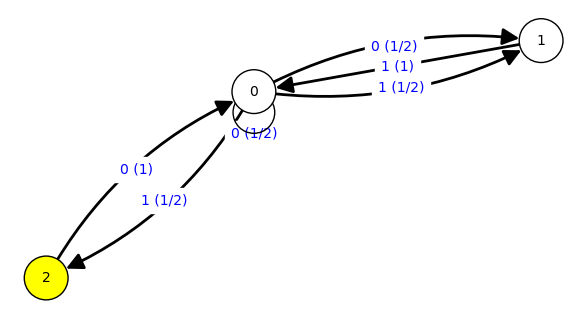

In [197]:
autplotwit((0,1,1,0,1),0)

In [27]:
#test1 = bruteforcevecs([ [0,0,1,0],[0,0,0,1],
#                        [0,0,0,0],[1/2,1/4,1/4,0],[0,1/2,1/4,1/4]],
#                      info=True)
test1 = bruteforceprobs(2,[1/1000,999/1000,1/2,1/2-1/1000,1/2+1/1000,1,0],half=True,info=True)

7 possible entries
8 rows
64 matrices
2016 matrix pairs


In [114]:
test2 = bruteforceprobs(4,[1/100,97/100],half=True,info=True)

2 possible entries
4 rows
256 matrices
32640 matrix pairs


In [4]:
test3=bruteforceprobs(3,[1/4,3/8,5/8,0],half=True,info=True)

4 possible entries
10 rows
1000 matrices
499500 matrix pairs


In [ ]:
eps1=1/1000
test4=bruteforceprobs(3,[eps1,1-eps1,1/2-eps1,1/2+eps1,1/3-eps1,2/3+eps1,1/3+eps1,2/3-eps1,0],half=True,info=True)

In [160]:
f2 = [1,0];
#uniq2 = finduniques(test2[11000:12000:],10,f2);
#uniq2 = finduniques(test3[301000:302000:13],10,f2);
uniq2 = finduniques(test4[::],5,f2);
print len(uniq2)
for s in Set([u[1][0][0] for u in uniq2]):
    if SC.has_key(s):
        print s,SC[s],NC[s];
    else:
        print s,"n/a",NC[s];

2539
(1, 1, 0, 1, 0) 2 3
(1, 1, 1, 1, 0) 2 2
(1, 1, 1, 0, 1) 2 3
(1, 0, 1, 0, 1) 2 2
(1, 0, 0, 0, 0) 2 2
(0, 0, 1, 1, 1) 2 3
(0, 0, 0, 0, 1) 2 2
(0, 0, 0, 1, 0) 2 3
(1, 1, 0, 0, 0) 2 3
(0, 0, 0, 0, 0) 1 1
(0, 0, 1, 0, 1) 2 3
(1, 0, 0, 0, 1) 2 3
(0, 1, 0, 0, 0) 2 3
(0, 1, 1, 1, 0) 2 3
(0, 1, 0, 1, 0) 2 2
(1, 0, 1, 1, 1) 2 3
(1, 1, 1, 1, 1) 1 1
(0, 1, 1, 1, 1) 2 2


In [161]:
#only bother adding witnesses if we don't already have one
#c = 0;
for u in uniq2:
    s = u[1][0][0];
    #don't bother if NC is lower, either
    if NC.has_key(s) and NC[s] < u[0][0].nrows(): continue;
    if not SW.has_key(s) or not SC.has_key(s) or SC[s] > u[0][0].nrows() or len(SW[s]) == 0:
        a = addonewit(u[0],s,f2);
        if a > 0:
            #c = c + a;
            print s,SC[s],a;
#print c

In [152]:
savewits()